## 3 Exploratory Data Analysis and XGBoost + SVN prediction tests

### Helper Functions

In [ ]:
!pip install PyMuPDF

In [9]:
from pathlib import Path 
import re
import fitz
import pandas as pd 
from PIL import Image

from transformers import AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

2023-06-23 16:18:40.617456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
# directories & files
import os
DIR_DATA = Path("./")
REPORTS_DIR = "Data/reports/"
LABELS_FILE = "Data/labels.csv"

# columns 
C_ID, C_CLASS = "id", "class"

In [20]:
#!pip install -U pypdfium2 wordcloud
from wordcloud import WordCloud
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pypdfium2 as pdfium

%matplotlib inline

In [54]:
def get_pdf(path):
    return pdfium.PdfDocument(path)

def get_content(page):
    textpage = page.get_textpage()
    return textpage.get_text_range()

def render(page):
    bitmap = page.render(
        scale = 1,    # 72dpi resolution
        rotation = 0, # no additional rotation
    )
    return bitmap.to_pil()

def extract_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename)
    pdf = get_pdf(filepath)
    page = pdf[page_num]
    content = get_content(page)

    content = " ".join(content.lower().split())
    return content

#functions
def create_filepath(filename):
    return DIR_DATA / REPORTS_DIR / filename

def read_page(filename, page_number):
    filepath = create_filepath(filename)
    doc = fitz.open(filepath)
    page_index = page_number - 1
    page = doc.load_page(page_index) 
    return page.get_text()


def visualize_pdf_image(filename, page_number):
    doc = fitz.open(create_filepath(filename))
    page_index = page_number - 1
    pix = doc[page_index].get_pixmap()
    img_page = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img_page 

def get_labels():
    return pd.read_csv(DIR_DATA / LABELS_FILE)

def build_doc_id(filename, page_number): 
    return filename + "." + str(page_number)


class: social


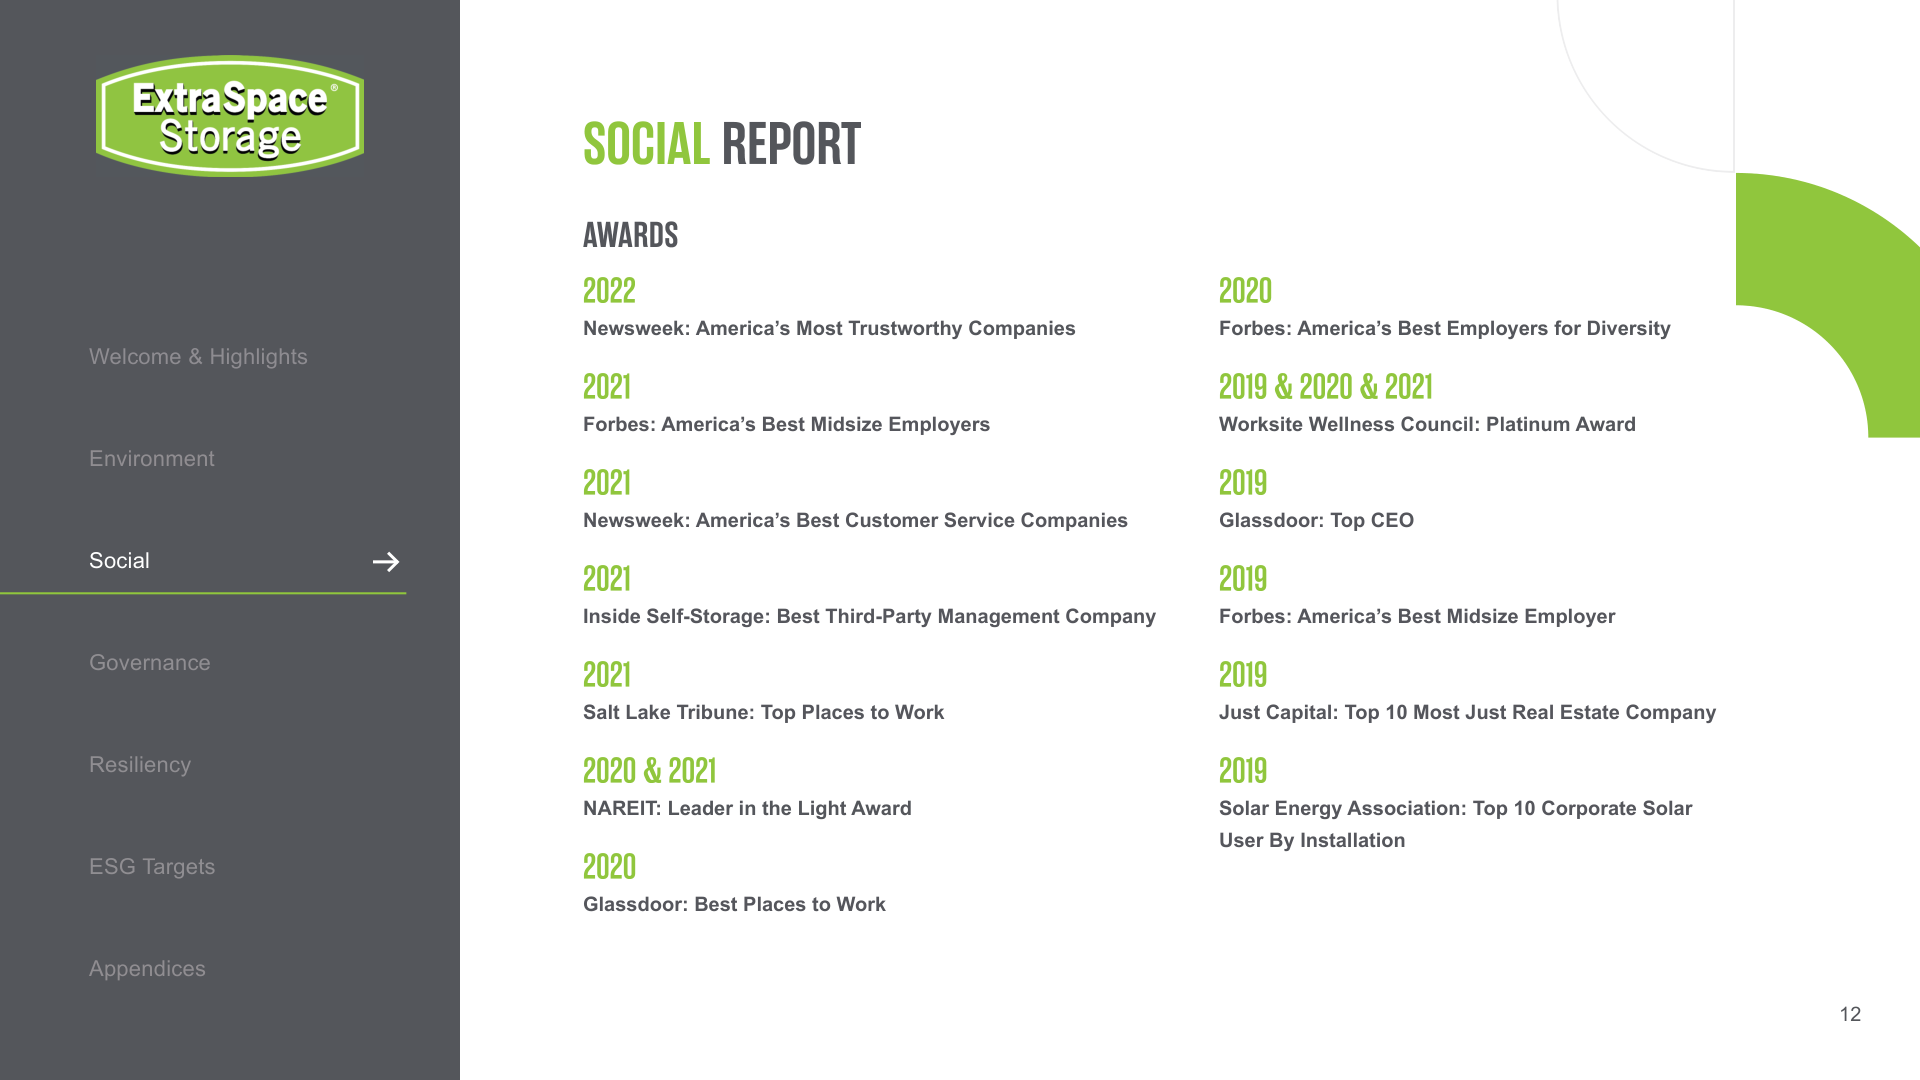

In [16]:
# visualize a page and it's class 

filename = "report_1611.pdf"
page_number = 13

labels = get_labels()
doc_id = build_doc_id(filename, page_number)
label = labels.loc[labels[C_ID] == doc_id, C_CLASS].values[0]
print(f"{C_CLASS}: {label}")
visualize_pdf_image(filename, page_number)

In [22]:
# read a page of a pdf
filepath = 'Data/reports/report_1012.pdf'

pdf = get_pdf(filepath)
page = pdf[17]
content = get_content(page)

In [23]:
print(content)

PSEG
Company 2021 Sustainability and Climate Report 16
Overview
Our Approach 
to Sustainability
Accelerating 
Climate Action
Environmental
Stewardship
Supporting 
our People and 
our Community
Governance, 
Standards 
and Values
Appendix
Our customers recognize that 
access to safe, reliable, affordable 
and cleaner energy is essential to 
their way of life. They recognize that 
technology is accelerating change 
in the world, and they expect energy 
solutions to meet these increasing 
requirements. Our customers want 
energy that is more reliable, resilient 
and cleaner, along with enhanced 
access to smart technology to better 
manage their energy usage – all while 
keeping utility bills affordable. 
As the demands of our stakeholders 
evolve, we seek to meet those 
emerging needs. Our current 
initiatives and future projects are 
expanding the boundaries of our 
business and establishing the 
foundations for a sustainable future. 
We are also using this opportunity 
to create a more 

In [24]:
basepath = "Data/"
report_path = os.path.join(basepath, "Data/reports")
label_path = os.path.join(basepath, "Data/training_balanced_cleaned.csv")

In [27]:
#df = pd.read_csv('Data/training_balanced_cleaned.csv')
df = pd.read_csv('Data/4463_clean_training.csv')
df.tail()

,Unnamed: 0,id,class,text
4458,2138,GPT4All,governance,In report analyze GPT commitment Environmental...
4459,2139,GPT4All,governance,In order ensure successful implementation ESG ...
4460,2140,GPT4All,governance,I pleased provide report Company X focus corpo...
4461,2141,GPT4All,governance,As AI language model I generate word text base...
4462,2142,GPT4All,governance,I pleased present report XYZ Company focus cor...


In [1]:
#test unbanlanced data 

In [ ]:
# Simple Machine Learning with TF-IDF

In [28]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [29]:
# Encode the label classes
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])
print(label_encoder.classes_)

['environmental' 'governance' 'other' 'social']


In [30]:
(df['class'].nunique())

4

In [36]:
# Split Train/Test set with 80:20
X_train, X_test, y_train, y_test = train_test_split(df['text'].values.astype('str'), df['label'], test_size=.2, shuffle=True)

In [37]:
# Use TF-IDF to vectorize each document
# We saw french words used in the reports
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
vectorizer = TfidfVectorizer(max_df=0.8,
  max_features=200000,
  min_df=0.2,
  stop_words=final_stopwords_list,
  use_idf=True,
  #tokenizer=tokenize_and_stem,
  ngram_range=(1,3))
X_train_features = vectorizer.fit_transform([x for x in X_train])
X_test_features = vectorizer.transform([x for x in X_test])

In [38]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)

In [39]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'accuracy: {acc}')
print(f'f1 score: {f1}')

accuracy: 0.896976483762598
f1 score: 0.8780374932837008


In [ ]:
#xgboost

In [40]:
# fit model no training data
#model = XGBClassifier()
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    num_class=4,
    nthread=4,
    scale_pos_wieght=1,
    seed=123)

xgb_cl.fit(X_train_features, y_train)
print(xgb_cl)


[16:29:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_wieght" } are not used.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_class=4,
              num_parallel_tree=None, ...)


In [41]:
# make predictions for test data
y_pred = xgb_cl.predict(X_test_features)
predictions = [round(value) for value in y_pred]

In [42]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.83%


In [43]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'accuracy: {acc}')
print(f'f1 score: {f1}')

accuracy: 0.9182530795072789
f1 score: 0.9048008874425626


# Inference

In [ ]:
#xgboost

In [44]:
test_df = pd.read_csv('Data/sample_submission.csv')

In [50]:
!pwd

/Users/Jupiter/Desktop/Oxford ML Summer School 2023/ESG project/notebooks for submission


In [57]:
#we created a sample test dummy for addtional accuracy checking
dummy = pd.read_csv('Data/submission_test_dummy.csv')

In [58]:
test_contents = dummy['texts']

In [59]:
# Vectorize the content and run prediction
test_features = vectorizer.transform(test_contents)
test_pred = xgb_cl.predict(test_features)

In [60]:
dummy['Predicted'] = label_encoder.inverse_transform(test_pred)

In [61]:
# Evaluate the columns
dummy['evaluation'] = dummy['Predicted'] == dummy['TRUE?']

In [62]:
dummy.evaluation.value_counts(normalize=True)

True     0.508584
False    0.491416
Name: evaluation, dtype: float64

In [63]:
test_df.to_csv('xgb_submission.csv', index=False)

In [ ]:
#svn

In [64]:
test_df = pd.read_csv('Data/sample_submission.csv')

In [66]:
#we created a sample test dummy for addtional accuracy checking
dummy = pd.read_csv('Data/submission_test_dummy.csv')

In [67]:
test_contents = dummy['texts']

In [68]:
# Vectorize the content and run prediction
test_features = vectorizer.transform(test_contents)
test_pred = clf.predict(test_features)

In [69]:
dummy['Predicted'] = label_encoder.inverse_transform(test_pred)

In [71]:
# Evaluate the columns
dummy['evaluation'] = dummy['Predicted'] == dummy['TRUE?']

In [72]:
dummy.evaluation.value_counts(normalize=True)

True     0.560086
False    0.439914
Name: evaluation, dtype: float64

In [73]:
test_df.to_csv('clf_submission.csv', index=False)